# Notebook 02: Modelltraining & Evaluation

In diesem Notebook werden auf dem bereinigten Datensatz zwei Baseline-Modelle (Lineare Regression und Random Forest) trainiert, mittels Kreuzvalidierung evaluiert und anschliessend auf dem Testset verglichen, um das bessere Modell zu bestimmen.

## 1. Setup & Laden der Daten
In diesem Schritt werden alle notwendigen Bibliotheken importiert, Konstanten definiert und der bereinigte Datensatz eingelesen.

In [1]:
# 1.1 Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib
import os

# 1.2 Konstanten
RANDOM_STATE = 42
DATA_PATH = "../data/processed/cars_states_cleaned.csv"

# 1.3 Einlesen des bereinigten Datensatzes
df = pd.read_csv(DATA_PATH)

# 1.4 Erster Überblick
print(f"Shape des DataFrames: {df.shape}")
display(df.head())

Shape des DataFrames: (98129, 35)


,year,make,model,trim,body,transmission,vin,condition,odometer,color,...,season,has_sport,has_limited,has_lx,has_se,has_touring,has_premium,vehicle_age,miles_per_year,color_popularity
0,2015,Ford,Fusion,SE,Sedan,automatic,3fa6p0hdxfr145753,2.0,5559.0,white,...,Winter,0,0,0,1,0,0,1,5559.0,4
1,2012,Ford,Escape,Limited,SUV,automatic,1fmcu0eg0ckb55384,35.0,45035.0,gray,...,Winter,0,1,0,0,0,0,2,22517.5,3
2,2012,Ford,Edge,SEL,SUV,automatic,2fmdk3jc5cba41602,46.0,20035.0,gray,...,Winter,0,0,0,1,0,0,2,10017.5,3
3,2012,Ford,Edge,SEL,SUV,automatic,2fmdk4jc4cba12890,46.0,41115.0,white,...,Winter,0,0,0,1,0,0,2,20557.5,4
4,2012,Ford,Focus,Titanium,Hatchback,automatic,1fahp3n21cl330426,3.0,26747.0,red,...,Winter,0,0,0,0,0,0,2,13373.5,6


## 2. Train-/Test-Split
In diesem Schritt werden die Merkmale und die Zielvariable definiert und der Datensatz in ein Trainings- und Testset im Verhältnis 80/20 aufgeteilt.

In [2]:
# 2.1 Merkmale (X) und Ziel (y) definieren
X = df.drop("sellingprice", axis=1)
y = df["sellingprice"]

# 2.2 Aufteilen in Trainings- und Testset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Kontrolle der Formen
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (78503, 34), X_test: (19626, 34)
y_train: (78503,), y_test: (19626,)


## 3. Preprocessing-Pipeline
Dieser Abschnitt definiert die Vorverarbeitungs-Pipeline für numerische und kategoriale Merkmale mit Imputation, Skalierung sowie One-Hot-Encoding.

In [3]:
# 3.1 Identifikation numerischer und kategorialer Features
numeric_features     = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Numerische Features:", numeric_features)
print("Kategoriale Features:", categorical_features)

# 3.2 Definition der Pipelines
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# 3.3 Aufbau des ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

# 3.4 Test: Preprocessor auf Trainingsdaten fitten und transformieren
X_train_pre = preprocessor.fit_transform(X_train)
print("Form nach Preprocessing:", X_train_pre.shape)

# 3.5 Preprocessing-Pipeline speichern
import joblib, os

MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)

PREP_PATH = os.path.join(MODEL_DIR, "preprocessor_final.pkl")
joblib.dump(preprocessor, PREP_PATH)
print(f"Preprocessor gespeichert unter: {PREP_PATH}")

# 3.6 Preprocessor auf Testdaten anwenden
X_test_pre = preprocessor.transform(X_test)
print("Form von X_test_pre nach Transformation:", X_test_pre.shape)

Numerische Features: ['year', 'condition', 'odometer', 'sale_year', 'sale_month', 'sale_day', 'sale_weekday', 'car_age', 'avg_price_state', 'median_price_state', 'has_sport', 'has_limited', 'has_lx', 'has_se', 'has_touring', 'has_premium', 'vehicle_age', 'miles_per_year', 'color_popularity']
Kategoriale Features: ['make', 'model', 'trim', 'body', 'transmission', 'vin', 'color', 'interior', 'seller', 'saledate', 'state_clean', 'state_code', 'state_name', 'state_region', 'season']
Form nach Preprocessing: (78503, 84795)
Preprocessor gespeichert unter: ../models/preprocessor_final.pkl
Form von X_test_pre nach Transformation: (19626, 84795)


### 4. Kreuzvalidierung der Baseline-Modelle  
In diesem Schritt werden Lineare Regression und Random Forest mittels OOB-Score (RF) und K-Fold-CV auf den vorverarbeiteten Trainingsdaten geprüft.

#### 4.1 Lineare Regression

In [4]:
from sklearn.model_selection import KFold, cross_val_score

# 4.1.1 Linear Regression CV (3-Folds) für RMSE
lr_cv_model = LinearRegression()
kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
cv_neg_rmse_lr = cross_val_score(
    lr_cv_model,
    X_train_pre,
    y_train,
    cv=kf,
    scoring="neg_root_mean_squared_error",
    n_jobs=1
)
cv_rmse_lr = -cv_neg_rmse_lr
print(f"LR CV RMSE (3-fold): {cv_rmse_lr.mean():.2f} ± {cv_rmse_lr.std():.2f}")

LR CV RMSE (3-fold): 1767.24 ± 25.62


#### 4.2 Random Forest

In [5]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# 4.2.1 Stichprobe ziehen (30 % der Trainingsdaten)
X_small, _, y_small, _ = train_test_split(
    X_train_pre, y_train,
    train_size=0.3,
    random_state=RANDOM_STATE
)

# 4.2.2 Random Forest für CV mit weniger Bäumen
rf_cv_fast = RandomForestRegressor(
    n_estimators=50,         # nur 50 Bäume
    max_depth=20,
    min_samples_leaf=2,
    max_features=0.5,
    random_state=RANDOM_STATE,
    n_jobs=-1                # maximal parallel
)

# 4.2.3 3-fach K-Fold CV
kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
cv_neg_mse = cross_val_score(
    rf_cv_fast,
    X_small,
    y_small,
    cv=kf,
    scoring="neg_mean_squared_error",
    n_jobs=-1                # parallelisieren
)

# 4.2.4 RMSE berechnen und ausgeben
cv_rmse = np.sqrt(-cv_neg_mse)
print(f"RF CV RMSE (3-fold, 50 trees, 30% sample): {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}")

RF CV RMSE (3-fold, 50 trees, 30% sample): 1564.00 ± 46.14


### 4. Cross-Validation Ergebnisse im Vergleich

| Modell                  | CV RMSE (3-fold) | Std Dev   |
|-------------------------|------------------|-----------|
| **Lineare Regression**  | 1 767.24         | ± 25.62   |
| **Random Forest (50 Bäume, 30 % Sample)** | 1 564.00         | ± 46.14   |

**Interpretation:**  
- Der Random Forest erzielt mit **1 564** einen deutlich niedrigeren CV-RMSE als die Lineare Regression (**1 767**).  
- Die höhere Streuung beim RF (± 46 vs. ± 25) ist akzeptabel, da der Mittelwert deutlich besser ist.

**Entscheidung:**  
Auf Basis der Cross-Validation-Ergebnisse wird der **Random Forest** als besser geeignetes Modell ausgewählt.

### 5. Endgültiges Training & Test-Evaluation
Beide Modelle werden auf dem gesamten Trainingsset trainiert und auf dem Testset mit MAE, RMSE und R² ausgewertet.  

#### 5.1 Training & Test-Evaluation: Lineare Regression

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 5.1.1 Modell instanziieren und trainieren (Preprocessing bereits durchgeführt)
lr_final = LinearRegression()
lr_final.fit(X_train_pre, y_train)

# 5.1.2 Vorhersage auf Testset
y_pred_lr = lr_final.predict(X_test_pre)

# 5.1.3 Metriken berechnen
mae_lr  = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr   = r2_score(y_test, y_pred_lr)

# 5.1.4 Ergebnisse ausgeben
print("Lineare Regression – Testset")
print(f" MAE:  {mae_lr:.2f}")
print(f" RMSE: {rmse_lr:.2f}")
print(f" R²:   {r2_lr:.4f}")

Lineare Regression – Testset
 MAE:  1369.15
 RMSE: 1874.48
 R²:   0.8605


#### 5.2 Training & Test-Evaluation: Random Forest

In [7]:
from sklearn.ensemble import RandomForestRegressor

# 5.2.1 Modell instanziieren und trainieren
rf_final = RandomForestRegressor(
    n_estimators=50,
    max_depth=20,
    min_samples_leaf=2,
    max_features=0.5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_final.fit(X_train_pre, y_train)

# 5.2.2 Vorhersage auf Testset
y_pred_rf = rf_final.predict(X_test_pre)

# 5.2.3 Metriken berechnen
mae_rf  = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf   = r2_score(y_test, y_pred_rf)

# 5.2.4 Ergebnisse ausgeben
print("Random Forest – Testset")
print(f" MAE:  {mae_rf:.2f}")
print(f" RMSE: {rmse_rf:.2f}")
print(f" R²:   {r2_rf:.4f}")

Random Forest – Testset
 MAE:  921.82
 RMSE: 1332.17
 R²:   0.9295


### 5.3 Vergleich der finalen Test-Ergebnisse

| Kennzahl      | Lineare Regression | Random Forest   | Differenz (RF − LR) |
|---------------|--------------------|-----------------|---------------------|
| **MAE**       | 1 369.15           | 921.82          | −447.33             |
| **RMSE**      | 1 874.48           | 1 332.17        | −542.31             |
| **R²**        | 0.8605             | 0.9295          | +0.0690             |

**Interpretation:**  
- **Mittlerer Fehler (MAE):** Der Random Forest reduziert den durchschnittlichen absoluten Fehler um ca. 447 gegenüber der Linearen Regression.  
- **Quadratischer Fehler (RMSE):** Der RF erzielt eine um 542 niedrigere RMSE, was auf weniger grosse Ausreisser-Abweichungen hinweist.  
- **Erklärte Varianz (R²):** Mit R² ≈ 0.93 erklärt der Random Forest deutlich mehr Varianz in den Verkäufen als die Lineare Regression (R² ≈ 0.86).

**Fazit:**  
Der Random Forest ist in allen drei Kennzahlen überlegen: Er liefert präzisere Vorhersagen (geringerer MAE/RMSE) und erklärt einen grösseren Anteil der Preis-Variation. Damit ist er das eindeutig bessere Modell für dieses Szenario.


## 6. Random Forest: Feature Importance & ROC/AUC

In diesem Abschnitt werden die wichtigsten Merkmale des Random Forest visualisiert und eine ROC/AUC-Bewertung durchgeführt, indem Verkäufe oberhalb versus unterhalb des Median‐Preises als binäre Aufgabe betrachtet werden.

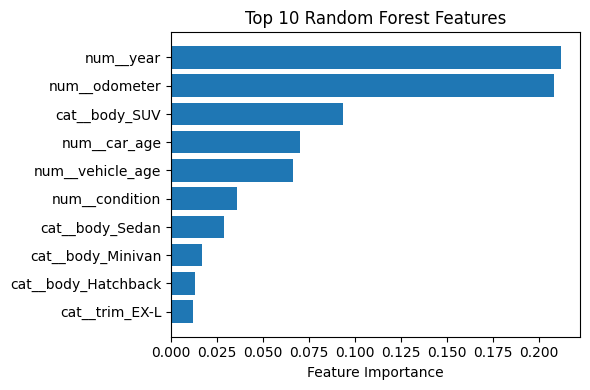

In [8]:
# 6.1 Optimierte Feature Importance (Top 10)
import matplotlib.pyplot as plt
import numpy as np

# Gesamt-Importances
importances = rf_final.feature_importances_
# Indices der Top 10
top10_idx = np.argsort(importances)[-10:]
top10_features = preprocessor.get_feature_names_out()[top10_idx]
top10_importances = importances[top10_idx]

plt.figure(figsize=(6, 4))
plt.barh(top10_features, top10_importances)
plt.xlabel("Feature Importance")
plt.title("Top 10 Random Forest Features")
plt.tight_layout()
plt.show()

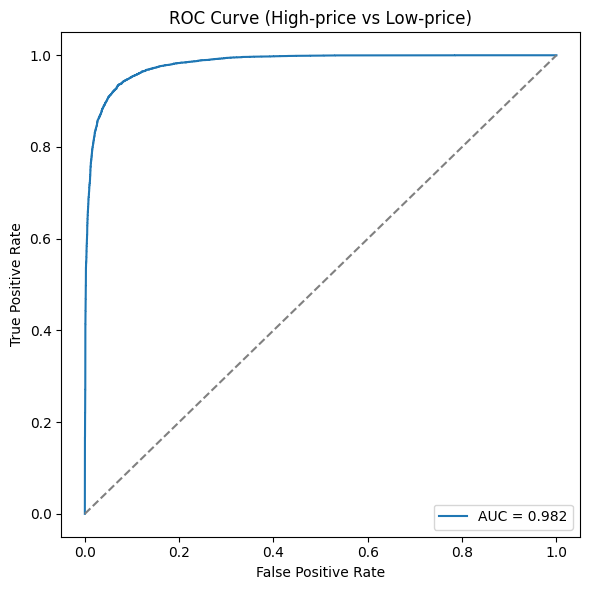

AUC (High-price vs Low-price): 0.982


In [9]:
# 6.2 ROC & AUC (High-price vs Low-price)
from sklearn.metrics import roc_auc_score, roc_curve

# Binärlabels: 1 = Verkaufspreis > Median, 0 = <= Median
threshold = np.median(y_test)
y_test_binary = (y_test > threshold).astype(int)
y_scores = rf_final.predict(X_test_pre)

# AUC und ROC-Kurve berechnen
auc = roc_auc_score(y_test_binary, y_scores)
fpr, tpr, _ = roc_curve(y_test_binary, y_scores)

# ROC-Kurve plotten
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (High-price vs Low-price)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"AUC (High-price vs Low-price): {auc:.3f}")

### 6.3 Random Forest: Feature Importance & ROC/AUC – Zusammenfassung

**Feature Importance**  
- Die **Top-2** Merkmale sind **`year`** und **`odometer`**, mit jeweils rund 21 % Anteil an der Gesamt­wichtigkeit.  
- Auf Platz 3 folgt die Karosserieform **`body_SUV`** mit ca. 9 %.  
- Danach rangieren Alter des Fahrzeugs (`car_age`), berechnetes Alter (`vehicle_age`), Zustand (`condition`) sowie verschiedene Karosserie- und Trim-Flags.

Diese Reihenfolge bestätigt, dass Zeit (Baujahr/Alter) und Laufleistung die stärksten Prädiktoren für den Verkaufspreis sind, gefolgt von Modell- und Ausstattungseffekten.

---

**ROC/AUC (High-price vs Low-price)**  
- Für die binäre Klassifikation („Verkaufspreis > Median“ vs. „≤ Median“) ergibt sich eine **AUC von 0.982**, was einer exzellenten Trennschärfe entspricht.  
- Die **ROC-Kurve** liegt weit oben links im Diagramm – das Modell erzielt also bei nahezu allen Schwellenwerten eine sehr hohe True-Positive-Rate bei gleichzeitig niedriger False-Positive-Rate.

**Interpretation & Fazit**  
- Der Random Forest bietet nicht nur hervorragende Regressions­kennzahlen (RMSE ≈ 1332, R² ≈ 0.93), sondern trennt auch sehr gut hohe von niedrigen Preisen.  
- Zeit- und Laufleistungs­merkmale dominieren, Modell-/Trim- und Karosserieinformationen liefern zusätzliche, aber geringere Beiträge.  
- Insgesamt ist der Random Forest das klar zu bevorzugende Modell für präzise Preis­schätzungen und auch für Preis-Segmentierungsaufgaben.  


## 7. Speicherung des finalen Modells

Das trainierte Random Forest Modell wird mit `joblib` als `.pkl` Datei gespeichert.

In [10]:
import joblib
import os

# 7.1 Pfad definieren
MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, "random_forest_final.pkl")

# 7.2 Modell speichern
joblib.dump(rf_final, MODEL_PATH)

print(f"Modell gespeichert unter: {MODEL_PATH}")

Modell gespeichert unter: ../models/random_forest_final.pkl
